# 라이브러리 가져오기

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.optimizers.legacy import SGD
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# 함수 정의

In [2]:
# 이미지 폴더에서 이미지 파일 경로를 가져오는 함수
def get_image_paths(folder_path):
    return [os.path.join(folder_path, filename) 
            for filename in os.listdir(folder_path) 
            if filename.endswith('.jpg')]
    
# 이미지를 로드하고 전처리하는 함수
def load_and_preprocess_image(image_path, size=(224, 224)):
    try:
        image = Image.open(image_path).resize(size)
        return np.array(image) / 255.0
    except Exception as e:
        print(f"Error loading image at {image_path}: {e}")
        return None


# 메타데이터를 로드하는 함수
def load_metadata(file_path):
    df = pd.read_csv(file_path)
    df['age'] = df['age'].fillna(df['age'].mean())
    df['age_normalized'] = (df['age'] - df['age'].mean()) / df['age'].std()
    return df
    
# 레이블을 인코딩하는 함수
def encode_labels(df, columns):
    encoders = {}
    for col in columns:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        encoders[col] = le
    return df, encoders
    
# 이미지를 증강하는 함수
def augment_images(images, category, data_gen, num_to_augment):
    augmented_images = []
    for x in images:
        x = x.reshape((1,) + x.shape)
        for _ in range(num_to_augment):
            augmented_images.append(data_gen.flow(x, batch_size=1).next()[0])
    return augmented_images

# 메타데이터에 이미지 경로를 추가하는 함수
def add_image_paths_to_metadata(metadata_df, image_paths):
    # 이미지 ID를 기반으로 경로를 찾아 'path' 열에 추가
    metadata_df['path'] = metadata_df['image_id'].apply(
        lambda x: next((path for path in image_paths if x in path), None))
    return metadata_df


# 랜덤 드롭아웃을 적용하는 함수
def apply_random_dropout(metadata, dropout_rate=0.1, unknown_value=-1):
    """
    metadata: 메타데이터 numpy 배열
    dropout_rate: 드롭아웃 확률
    unknown_value: 알 수 없는 값에 대한 표시 (예: -1)
    """
    for i in range(metadata.shape[1]):
        for j in range(metadata.shape[0]):
            if random.random() < dropout_rate:
                metadata[j, i] = unknown_value
    return metadata


# 모델 학습 중 일정 배치 단계마다 학습을 중단시키는 콜백 클래스
class FixedStepStopping(Callback):
    def __init__(self, step):
        super(FixedStepStopping, self).__init__()
        self.step = step

    def on_batch_end(self, batch, logs=None):
        if (batch + 1) % self.step == 0:
            self.model.stop_training = True



# 모델 성능 그래프를 그리는 함수
def plot_performance(history, val_accuracy, val_loss, title):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(12, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=val_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.axhline(y=val_loss, color='r', linestyle='--', label='Test Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# 이미지 및 메타데이터 불러오기

In [3]:
# 데이터 로딩
folder_path_1 = '/Users/choejong-gyu/Downloads/archive/HAM10000_images_part_1'
folder_path_2 = '/Users/choejong-gyu/Downloads/archive/HAM10000_images_part_2'
metadata_file_path = '/Users/choejong-gyu/Downloads/archive/HAM10000_metadata.csv'

image_paths = get_image_paths(folder_path_1) + get_image_paths(folder_path_2)
metadata_df = load_metadata(metadata_file_path)
metadata_df, encoders = encode_labels(metadata_df, ['sex', 'localization', 'dx'])
metadata_df = add_image_paths_to_metadata(metadata_df, image_paths)

In [4]:
metadata_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,age_normalized,sex_encoded,localization_encoded,dx_encoded,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,1.662870,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,1.662870,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,1.662870,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,1.662870,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,1.367366,1,4,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,-0.701161,1,0,0,/Users/choejong-gyu/Downloads/archive/HAM10000...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,-0.701161,1,0,0,/Users/choejong-gyu/Downloads/archive/HAM10000...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,-0.701161,1,0,0,/Users/choejong-gyu/Downloads/archive/HAM10000...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,1.662870,1,5,0,/Users/choejong-gyu/Downloads/archive/HAM10000...


# EDA

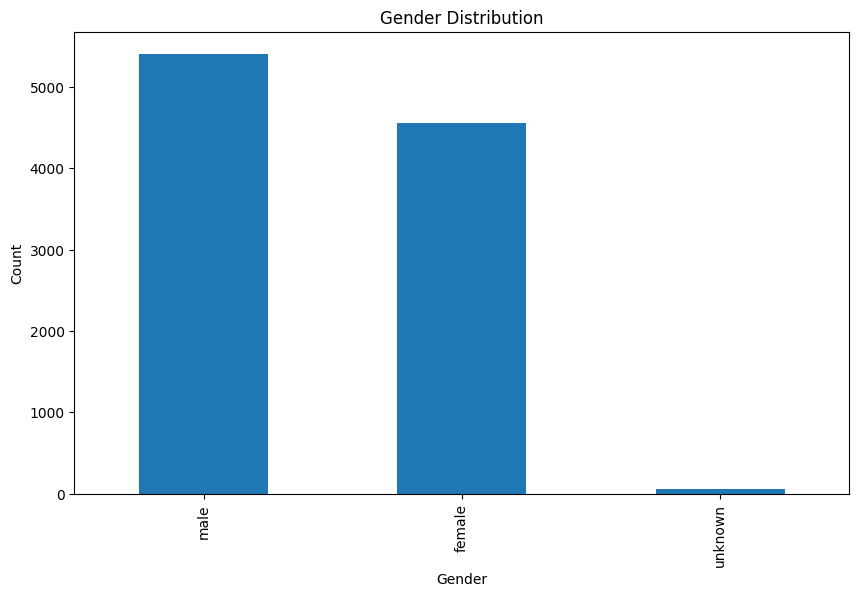

In [5]:
import matplotlib.pyplot as plt

# 성별(sex)별 데이터 수를 가져옵니다.
sex_counts = metadata_df['sex'].value_counts()

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 막대 그래프 생성
sex_counts.plot(kind='bar')

# 그래프 제목과 레이블 설정
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# 그래프 표시
plt.show()


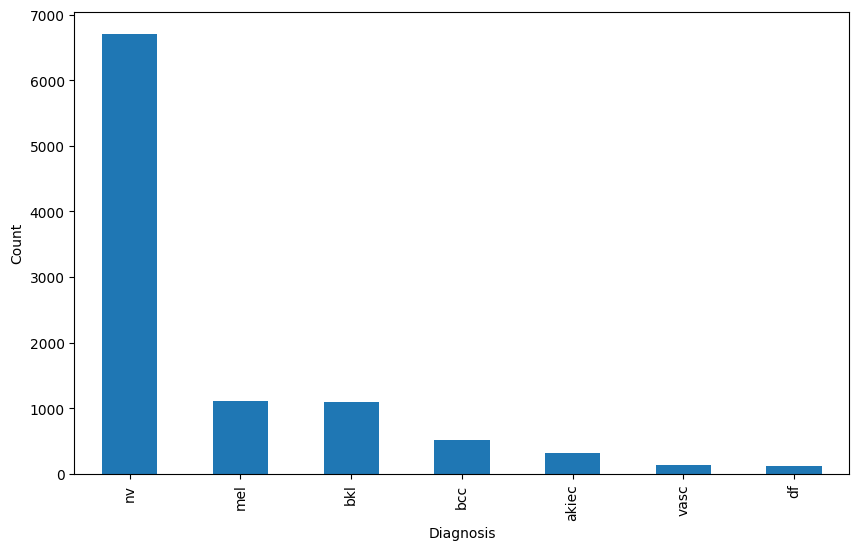

In [6]:
import matplotlib.pyplot as plt

# 진단 코드(dx)별 데이터 수를 가져옵니다.
diagnosis_counts = metadata_df['dx'].value_counts()

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 막대 그래프 생성
diagnosis_counts.plot(kind='bar')

# 그래프 제목과 레이블 설정

plt.xlabel('Diagnosis')
plt.ylabel('Count')

# 그래프 표시
plt.show()


# 데이터 증강

In [7]:
# 데이터 증강을 위한 설정
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # 밝기 조정
    channel_shift_range=20.0       # 채널 이동을 통한 색상 변형
)

# 데이터 불균형으로 인한 균형 맞추기

In [8]:
# 클래스별 이미지 분류
class_images = {dx: [] for dx in metadata_df['dx'].unique()}
for idx, row in metadata_df.iterrows():
    image = load_and_preprocess_image(row['path'])
    if image is not None:
        class_images[row['dx']].append(image)

# 각 클래스별로 이미지 개수 조정
target_size = 1000
adjusted_class_images = {}
for dx, imgs in class_images.items():
    if len(imgs) < target_size:
        # 데이터 증강으로 이미지 개수 증가
        num_to_augment = target_size - len(imgs)
        augmented_imgs = augment_images(imgs, dx, data_gen, num_to_augment // len(imgs) + 1)
        adjusted_class_images[dx] = imgs + augmented_imgs[:num_to_augment]
    else:
        # 이미지 개수 줄이기
        selected_indices = np.random.choice(range(len(imgs)), target_size, replace=False)
        adjusted_class_images[dx] = [imgs[i] for i in selected_indices]

# 결과 확인
for dx, imgs in adjusted_class_images.items():
    print(f"{dx}: {len(imgs)} images")

bkl: 1000 images
nv: 1000 images
df: 1000 images
mel: 1000 images
vasc: 1000 images
bcc: 1000 images
akiec: 1000 images


# 이미지 증강된 이미지와 메타데이터 결합

In [9]:
# LabelEncoder 인스턴스 초기화
label_encoder_sex = LabelEncoder()
label_encoder_localization = LabelEncoder()
label_encoder_dx = LabelEncoder()
# 조정된 이미지 데이터와 메타데이터 결합
adjusted_images = []
adjusted_metadata = []
for dx, imgs in adjusted_class_images.items():
    for img in imgs:
        adjusted_images.append(img)
        adjusted_metadata.append(metadata_df[metadata_df['dx'] == dx].iloc[0])


In [10]:
# 메타데이터 DataFrame으로 변환
adjusted_metadata_df = pd.DataFrame(adjusted_metadata)

adjusted_metadata_df['sex_encoded'] = encoders['sex'].transform(adjusted_metadata_df['sex'])
adjusted_metadata_df['localization_encoded'] = encoders['localization'].transform(adjusted_metadata_df['localization'])
adjusted_metadata_df['dx_encoded'] = encoders['dx'].transform(adjusted_metadata_df['dx'])

# 이미지 데이터를 NumPy 배열로 변환
adjusted_images_np = np.array(adjusted_images)

# 원-핫 인코딩
labels_one_hot = to_categorical(adjusted_metadata_df['dx_encoded'])

# 메타데이터 선택 (나이, 성별, 질환 부위)
meta_data = adjusted_metadata_df[['age_normalized', 'sex_encoded', 'localization_encoded']].values


# 데이터 분할

In [11]:
X_train_img, X_test_img, y_train_img, y_test_img, X_train_meta, X_test_meta = train_test_split(
    adjusted_images_np, labels_one_hot, meta_data, test_size=0.2, random_state=42, stratify=labels_one_hot)

X_train_img, X_val_img, y_train_img, y_val_img, X_train_meta, X_val_meta = train_test_split(
    X_train_img, y_train_img, X_train_meta, test_size=0.25, random_state=42, stratify=y_train_img)

# 랜덤 드롭아웃 적용
X_train_meta = apply_random_dropout(X_train_meta, dropout_rate=0.1, unknown_value=-1)

## 데이터 타입 변경

In [12]:
# 데이터 타입 변환
X_train_img = X_train_img.astype('float32')
X_val_img = X_val_img.astype('float32')
X_test_img = X_test_img.astype('float32')
X_train_meta = X_train_meta.astype('float32')
X_val_meta = X_val_meta.astype('float32')
X_test_meta = X_test_meta.astype('float32')

# 콜백 함수

In [13]:
# 얼리 스톱 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# FixedStepStopping 콜백을 모델 훈련 시 사용
fixed_step_stopping = FixedStepStopping(step=100000)

# CNN모델 및 메타데이터 모델 결합

In [14]:
# 메타데이터 차원수와 클래스 수 설정
meta_data_dim = 3  # 예시: 메타데이터에 3개의 특징이 있다고 가정
num_classes = 7    # 예시: 분류해야 할 클래스 수

# 이미지 처리를 위한 CNN 모델
image_input = Input(shape=(224, 224, 3), name='image_input')
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
x = base_model(image_input)
x = GlobalAveragePooling2D()(x)
image_features = Dense(128, activation='relu')(x)

# 메타데이터 처리를 위한 별도의 신경망
metadata_input = Input(shape=(meta_data_dim,), name='metadata_input')
metadata_features = Dense(64, activation='relu')(metadata_input)

# Late fusion: 두 모델의 출력을 결합
concatenated = Concatenate()([image_features, metadata_features])
output = Dense(num_classes, activation='softmax')(concatenated)

# 최종 모델
final_model = Model(inputs=[image_input, metadata_input], outputs=output)

# 모델 컴파일 및 훈련
final_model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history = final_model.fit([X_train_img, X_train_meta], y_train_img, epochs=50, validation_data=([X_val_img, X_val_meta], y_val_img),callbacks=[early_stopping, fixed_step_stopping])

2024-01-24 12:49:58.148741: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-24 12:49:58.149526: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-24 12:49:58.149540: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-24 12:49:58.149767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-24 12:49:58.150154: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-01-24 12:50:13.116948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 185s 1s/step - loss: 1.2563 - accuracy: 0.5531 - val_loss: 0.8706 - val_accuracy: 0.6979
Epoch 2/50
132/132 [==============================] - 151s 1s/step - loss: 0.7269 - accuracy: 0.7745 - val_loss: 0.5426 - val_accuracy: 0.8100
Epoch 3/50
132/132 [==============================] - 149s 1s/step - loss: 0.5905 - accuracy: 0.8157 - val_loss: 0.4366 - val_accuracy: 0.8221
Epoch 4/50
132/132 [==============================] - 153s 1s/step - loss: 0.4971 - accuracy: 0.8552 - val_loss: 0.3849 - val_accuracy: 0.8971
Epoch 5/50
132/132 [==============================] - 152s 1s/step - loss: 0.4406 - accuracy: 0.8690 - val_loss: 0.3316 - val_accuracy: 0.9214
Epoch 6/50
132/132 [==============================] - 152s 1s/step - loss: 0.3889 - accuracy: 0.8962 - val_loss: 0.3360 - val_accuracy: 0.9314
Epoch 7/50
132/132 [==============================] - 154s 1s/step - loss: 0.3396 - accuracy: 0.9121 - val_loss: 0.3322 - val_accuracy: 0.9236
Epoch 8/50

# 모델 저장

In [15]:
final_model.save('/Users/choejong-gyu/Documents/GitHub/skindisease/final_model5.h5')

/Users/choejong-gyu/miniforge3/envs/tf_metal/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 테스트 평가

In [18]:
# 테스트 데이터셋을 사용하여 모델 평가
test_loss, test_accuracy = final_model.evaluate([X_test_img, X_test_meta], y_test_img)

# 평가 결과 출력
print("테스트 데이터에 대한 손실: {:.4f}".format(test_loss))
print("테스트 데이터에 대한 정확도: {:.2f}%".format(test_accuracy * 100))


44/44 [==============================] - 13s 297ms/step - loss: 0.2751 - accuracy: 0.9307
테스트 데이터에 대한 손실: 0.2751
테스트 데이터에 대한 정확도: 93.07%


# 성능 리포트 및 혼동행렬 생성

44/44 [==============================] - 14s 318ms/step
분류 리포트:
                     precision    recall  f1-score   support

             피부 선암       0.94      0.94      0.94       200
             기저세포암       0.89      0.94      0.91       200
벤인 케라토시스 라이크 레이즈니즈       0.90      0.89      0.89       200
            피부 섬유종       0.97      0.98      0.97       200
               흑색종       0.97      0.85      0.91       200
           멜라닌성 낭종       0.87      0.93      0.90       200
             혈관 병변       0.99      0.99      0.99       200

          accuracy                           0.93      1400
         macro avg       0.93      0.93      0.93      1400
      weighted avg       0.93      0.93      0.93      1400



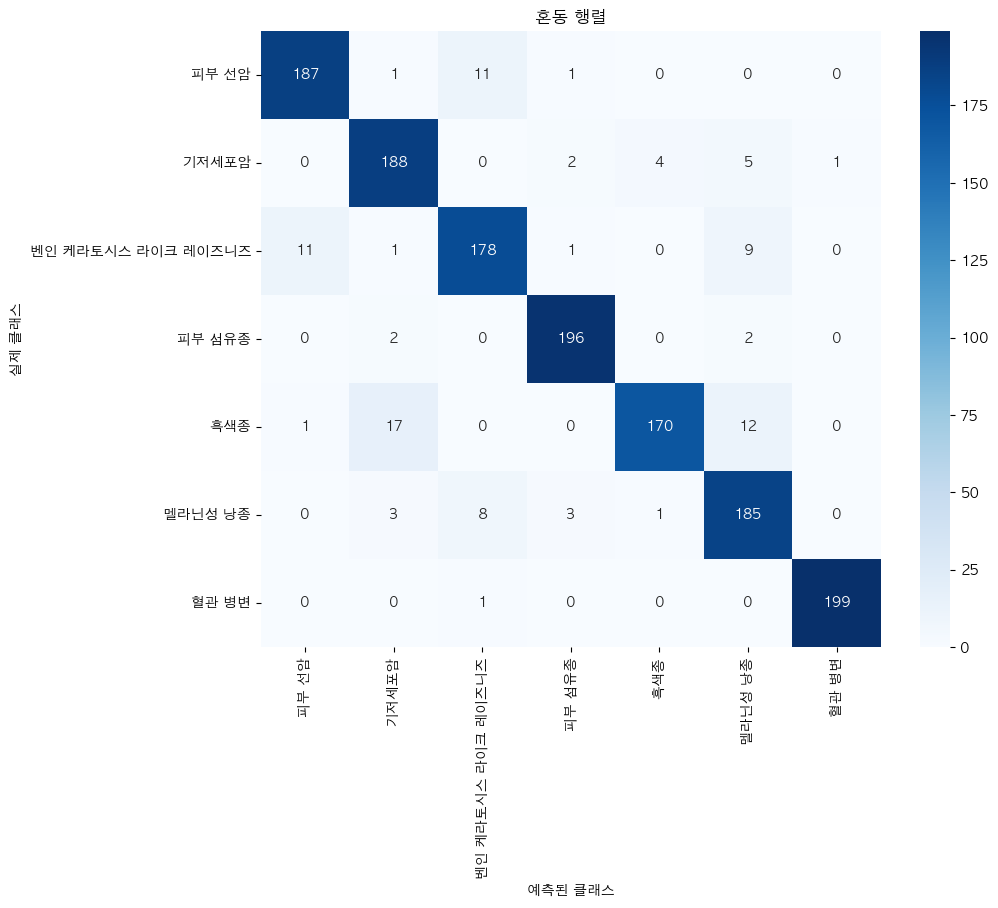

In [23]:
class_names = {
    0: '피부 선암',
    1: '기저세포암',
    2: '벤인 케라토시스 라이크 레이즈니즈',
    3: '피부 섬유종',
    4: '흑색종',
    5: '멜라닌성 낭종',
    6: '혈관 병변'
}

# 테스트 데이터에 대한 예측 수행
y_pred = final_model.predict([X_test_img, X_test_meta])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_img, axis=1)

# 성능 리포트 생성
report = classification_report(y_true, y_pred_classes, target_names=class_names.values())
print("분류 리포트:\n", report)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_true, y_pred_classes)


# 한글 폰트 설정
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('예측된 클래스')
plt.ylabel('실제 클래스')
plt.title('혼동 행렬')
plt.show()


# 결합된 모델의 정확도 및 손실

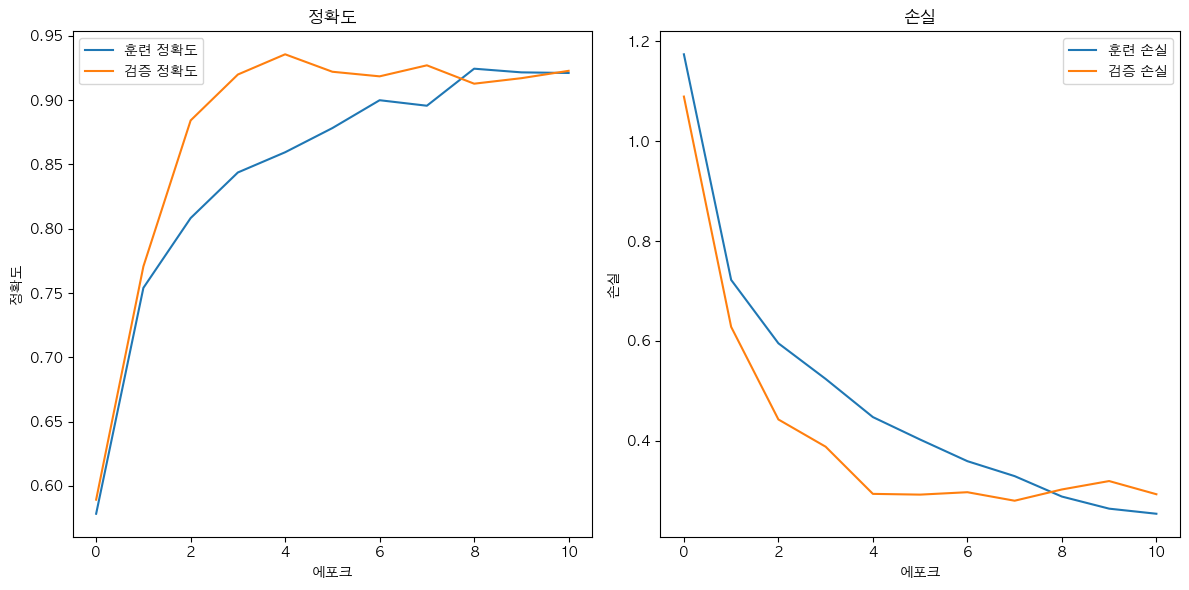

In [30]:
# 훈련 히스토리 가져오기
history = final_model.history.history

# 서브플롯 생성
plt.figure(figsize=(12, 6))

# 첫 번째 서브플롯: 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='훈련 정확도')
plt.plot(history['val_accuracy'], label='검증 정확도')
plt.title('정확도')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend(loc='upper left')

# 두 번째 서브플롯: 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='훈련 손실')
plt.plot(history['val_loss'], label='검증 손실')
plt.title('손실')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend(loc='upper right')

plt.tight_layout()  # 그래프 간격 조정
plt.show()


# 메타데이터를 입력받고 이미지를 업로드하였을 때 예측 값구하기

In [22]:
# 함수 정의
def load_metadata(file_path):
    return pd.read_csv(file_path)

def get_user_input():
    age = float(input("나이를 입력하세요: "))
    sex_input = input("성별을 입력하세요 (남자/여자): ")
    localization_input = input("질환 부위를 입력하세요 (예: 얼굴, 머리): ")
    return age, sex_input, localization_input

def encode_user_input(metadata_df, age, sex_input, localization_input):
    sex_dict = {"남자": "male", "여자": "female"}
    # 질환 부위를 영어로 변환
    localization_dict = {
        "복부": "abdomen",
        "등": "back",
        "가슴": "chest",
        "얼굴": "face",
        "발": "foot",
        "생식기": "genital",
        "다리": "lower extremity",
        "목": "neck",
        "두피": "scalp",
        "몸통": "trunk",
        "알수없음": "unknown",
        "팔": "upper extremity",
        "귀" : "ear",
        "손바닥" : "acral",
        "손" : "hand",
    }
    sex = sex_dict.get(sex_input, "unknown")
    localization = localization_dict.get(localization_input, "unknown")
    sex_encoded = 0 if sex == "male" else 1
    label_encoder = LabelEncoder().fit(metadata_df['localization'])
    localization_encoded = label_encoder.transform([localization])[0]
    return np.array([[age, sex_encoded, localization_encoded]])

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    return np.expand_dims(img_array, axis=0) / 255.0

def predict_skin_disease(model, img_array, meta_input):
    # 모델에 두 개의 입력을 제공
    predictions = model.predict([img_array, meta_input])
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names.get(predicted_class_index, "알 수 없음")
    predicted_class_probability = predictions[0][predicted_class_index]
    return predicted_class_index, predicted_class_name, predicted_class_probability


# 질환 클래스 이름 매핑 (실제 데이터에 맞게 수정 필요)
class_names = {
    0: '피부 선암 (Actinic keratoses and intraepithelial carcinoma)',
    1: '기저세포암 (Basal cell carcinoma)',
    2: '벤인 케라토시스 라이크 레이즈니즈 (Benign keratosis-like lesions)',
    3: '피부 섬유종 (Dermatofibroma)',
    4: '흑색종 (Melanoma)',
    5: '멜라닌성 낭종 (Melanocytic nevi)',
    6: '혈관 병변 (Vascular lesions)'
}

# 메타데이터 로드
metadata_df = load_metadata('/Users/choejong-gyu/Downloads/archive/HAM10000_metadata.csv')

# 모델 로드
model = load_model('final_model2.h5')

# 사용자 입력 받기
age, sex_input, localization_input = get_user_input()

# 입력 데이터 인코딩
meta_input = encode_user_input(metadata_df, age, sex_input, localization_input)

# 이미지 처리
image_path = '/Users/choejong-gyu/Downloads/archive/HAM10000_images_part_2/ISIC_0033536.jpg'  # 실제 이미지 경로로 변경
img_array = preprocess_image(image_path)

# 예측 수행
predicted_class_index, predicted_class_name, predicted_class_probability = predict_skin_disease(model, img_array, meta_input)

# 결과 출력
print(f"예측된 피부 질환 클래스 인덱스: {predicted_class_index}")
print(f"예측된 피부 질환 클래스 이름: {predicted_class_name}")
print(f"예측된 피부 질환 클래스 확률: {predicted_class_probability:.4f}")


나이를 입력하세요:  40
성별을 입력하세요 (남자/여자):  남자
질환 부위를 입력하세요 (예: 얼굴, 머리):  복부


1/1 [==============================] - 7s 7s/step
예측된 피부 질환 클래스 인덱스: 3
예측된 피부 질환 클래스 이름: 피부 섬유종 (Dermatofibroma)
예측된 피부 질환 클래스 확률: 0.9999


# 단일 CNN모델과 결합된 모델의 비교

In [16]:
# 단일 CNN 모델 구축
cnn_model_input = Input(shape=(224, 224, 3), name='cnn_model_input')
base_cnn_model = InceptionResNetV2(weights='imagenet', include_top=False)(cnn_model_input)
x = GlobalAveragePooling2D()(base_cnn_model)
cnn_output = Dense(num_classes, activation='softmax')(x)
cnn_model = Model(inputs=cnn_model_input, outputs=cnn_output)
# 모델 컴파일
cnn_model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
# 모델 훈련
cnn_history = cnn_model.fit(X_train_img, y_train_img, epochs=50, validation_data=(X_val_img, y_val_img), callbacks=[early_stopping])


Epoch 1/50
132/132 [==============================] - 192s 1s/step - loss: 1.5473 - accuracy: 0.3471 - val_loss: 1.9500 - val_accuracy: 0.2707
Epoch 2/50
132/132 [==============================] - 148s 1s/step - loss: 1.3379 - accuracy: 0.4179 - val_loss: 1.4991 - val_accuracy: 0.3757
Epoch 3/50
132/132 [==============================] - 149s 1s/step - loss: 1.1972 - accuracy: 0.4726 - val_loss: 1.1695 - val_accuracy: 0.4886
Epoch 4/50
132/132 [==============================] - 148s 1s/step - loss: 1.0795 - accuracy: 0.5224 - val_loss: 1.3538 - val_accuracy: 0.4329
Epoch 5/50
132/132 [==============================] - 147s 1s/step - loss: 1.0066 - accuracy: 0.5493 - val_loss: 1.2608 - val_accuracy: 0.4593
Epoch 6/50
132/132 [==============================] - 149s 1s/step - loss: 0.9141 - accuracy: 0.5807 - val_loss: 1.0897 - val_accuracy: 0.5250
Epoch 7/50
132/132 [==============================] - 147s 1s/step - loss: 0.8194 - accuracy: 0.6233 - val_loss: 1.1330 - val_accuracy: 0.5221

In [17]:
# CNN 모델 성능 평가
cnn_val_loss, cnn_val_accuracy = cnn_model.evaluate(X_val_img, y_val_img)
# CNN + 메타데이터 모델 성능 평가
combined_val_loss, combined_val_accuracy = final_model.evaluate([X_val_img, X_val_meta], y_val_img)
# 성능 비교 출력
print("CNN Model - Accuracy: {:.2f}, Loss: {:.2f}".format(cnn_val_accuracy, cnn_val_loss))
print("CNN + Metadata Model - Accuracy: {:.2f}, Loss: {:.2f}".format(combined_val_accuracy, combined_val_loss))


44/44 [==============================] - 15s 330ms/step - loss: 0.2605 - accuracy: 0.9414
CNN Model - Accuracy: 0.52, Loss: 1.09
CNN + Metadata Model - Accuracy: 0.94, Loss: 0.26


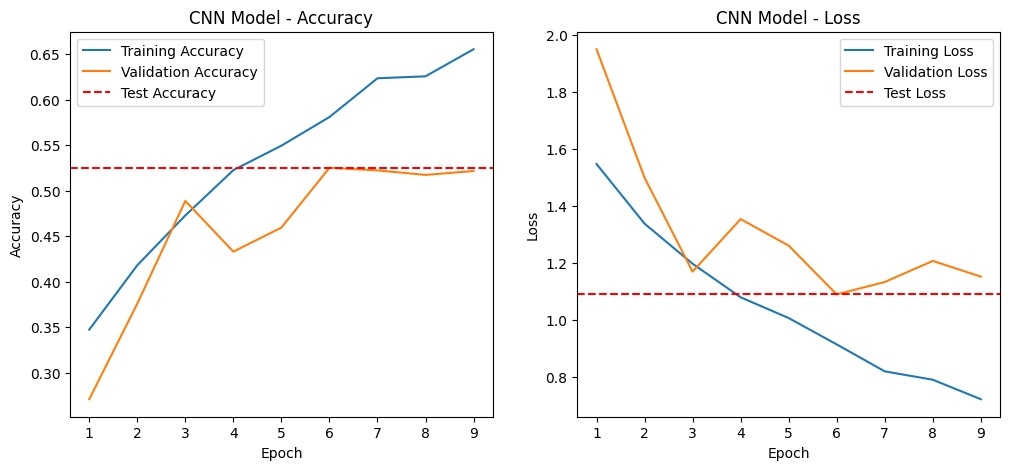

In [19]:
# CNN 모델의 성능 시각화
plot_performance(cnn_history, cnn_val_accuracy, cnn_val_loss, 'CNN Model')

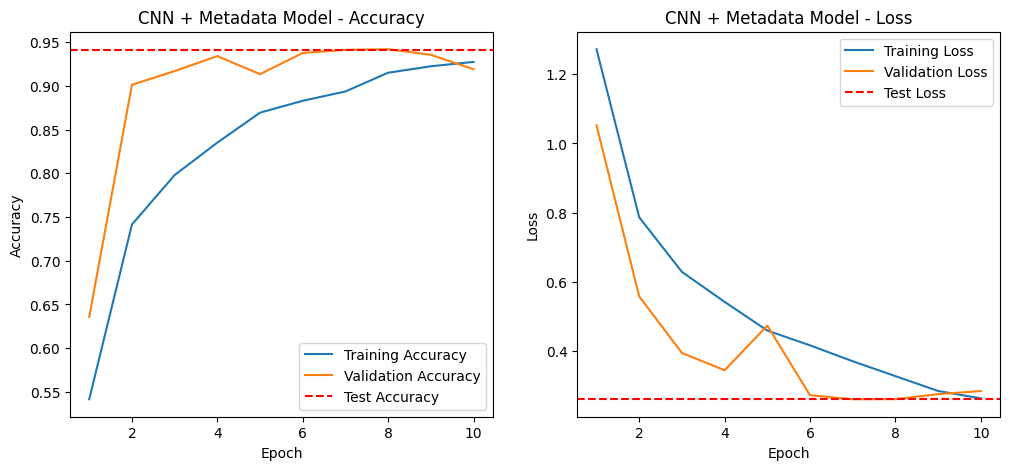

In [20]:
# CNN + 메타데이터 모델의 성능 시각화
plot_performance(history, combined_val_accuracy, combined_val_loss, 'CNN + Metadata Model')

In [ ]:
# 메타데이터의 부족함으로 인해 예측을 잘 못하는 거 같고 (캐글 데이터의 부족) 메타데이터 3개밖에 없거니와 중요한 메타데이터가 부족함(이전에 앓았던 질환, 현재 열이 있는지 등등)

# 이미지 Segmataion 이후 cnn모델과 결합하면 더 좋은 결과가 나오겠지만 이미지 분할을 하기위한 마스킹데이터가 없기에 성능부족


In [ ]:
# 랜덤포레스트 모델을 통해 특성추출 시각화